# Entrenamiento de modelos de aprendizaje con el dataset Polyvore

**Autor:** Roberto Araya Day

**Fecha de inicio:** 16/11/2022

## 1. Preparación de datos

- El archivo *type_aware_polyvore_outfits.py* es el script de **Learning Type Aware Embeddings for Fashion Compatibility** para cargar el dataset de Polyvore y crear ejemplos. Se define un **TripletImageLoader** con una serie de transformaciones para las imágenes. Este archivo retorna *Triplets* de imágenes postivas y negativas. Modificamos este archivo en la forma de **DoubletImageLoader** para retornar pares de imágenes. Revisar el archivo. 
- El archivo *similarity_conditions_triplet_image_loader.py* es el script de **Learning similarity Conditions** para cargar triplets de datos de Polyvore. Revisar.

- Se dividen en los archivos:
    - ***fashion_compatibility_prediction.txt***: En ***fashion_compatibility_prediction_val.txt*** y ***fashion_compatibility_prediction_test.txt*** para las métricas de validación y testeo. Puesto que el archivo contiene **7076** columnas, se ponen **3538** ejemplos en cada archivo.
    - ***fill_in_blank_test.txt***.
---

Los modelos de recomendación están conformados por la siguiente estructura:
1. **DoubletImageLoader**: Carga las imágenes, con sus metadatos, y se crean los ejemplos de pares de prendas positivos. Es decir, prendas compatibles. Esta basado en los dataloader de ambas investigaciones señaladas anteriormente.
    - Un DataLoader es una estructura que combina un dataset y un sampler, y provee un iterador sobre el dataset.


2. **DoubletNet**: Genera los embeddings y calcula la pérdida y distancia entre los vectores obtenidos de los ejemplos positivos. No se necesita para este caso, puesto que el **Modelo General** lo hace por si solo. No necesita obtener el loss o accuracy de los pares de imágenes.


3. **Modelo General**: Variante del modelo BYOL que recibe dos imágenes de entrada.

In [6]:
import sys
import os
sys.path.append('/home/raraya/miniconda3/envs/fashion_model/lib/python3.10/site-packages')

In [7]:
# path to important folders
polyvore_dataset = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'polyvore_data')
polyvore_images = os.path.join(polyvore_dataset, 'images')
polyvore_info = os.path.join(polyvore_dataset, 'polyvore-info')

polyvore_train = os.path.join(polyvore_info, 'train_no_dup')
polyvore_val = os.path.join(polyvore_info, 'valid_no_dup')
polyvore_test = os.path.join(polyvore_info, 'test_no_dup')

## 2. Instalación de los modelos de aprendizaje
### 2.1 Instalación del modelo BYOL

   Se instala la variante del modelo BYOL del trabajo de *Javier Morales Rodriguez* del repositorio *bimodal-byol-shoes*:
- https://github.com/javier-op/bimodal-byol-shoes.

In [8]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
%reload_ext autoreload

In [10]:
%autoreload 2

In [11]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import Resnet_18
from polyvore_outfits import TripletImageLoader
from tripletnet_original import Tripletnet
from type_specific_network import TypeSpecificNet
import sys


test_arg = True
use_fc_arg = True
learned_arg = True
prein_arg = True
epochs_args = 10
batch_size_args = 96
learning_rate_args = 5e-5
num_conditions = 5
learned_metric_arg = False


# names of model
name_arg = 'type_aware_%s_epochs_fc_%s_prein_%s' % (epochs_args, use_fc_arg, prein_arg)
resume_arg =  'runs/precise_models/%s/checkpoint.pth.tar' % (name_arg)

# Training settings
parser = argparse.ArgumentParser(description='Fashion Compatibility Example')
parser.add_argument('--batch-size', type=int, default=batch_size_args, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', type=int, default=epochs_args, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--start_epoch', type=int, default=1, metavar='N',
                    help='number of start epoch (default: 1)')
parser.add_argument('--lr', type=float, default=learning_rate_args, metavar='LR',
                    help='learning rate (default: 5e-5)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--resume', default=resume_arg, type=str,
                    help='path to latest checkpoint (default: none)')

parser.add_argument('--name', default=name_arg, type=str,
                    help='name of experiment')
parser.add_argument('--polyvore_split', default='nondisjoint', type=str,
                    help='specifies the split of the polyvore data (either disjoint or nondisjoint)')
parser.add_argument('--datadir', default='../../polyvore_type_aware_data', type=str,
                    help='directory of the polyvore outfits dataset (default: data)')
parser.add_argument('--test', dest='test', action='store_true', default=test_arg,
                    help='To only run inference on test set')
parser.add_argument('--dim_embed', type=int, default=64, metavar='N',
                    help='how many dimensions in embedding (default: 64)')
parser.add_argument('--use_fc', action='store_true', default=use_fc_arg,
                    help='Use a fully connected layer to learn type specific embeddings.')
parser.add_argument('--learned', dest='learned', action='store_true', default=learned_arg,
                    help='To learn masks from random initialization')
parser.add_argument('--prein', dest='prein', action='store_true', default=prein_arg,
                    help='To initialize masks to be disjoint')
parser.add_argument('--num_heads', dest='num_heads', action='store_true', default=4,
                    help='Amount of heads on')

parser.add_argument('--rand_typespaces', action='store_true', default=False,
                    help='randomly assigns comparisons to type-specific embeddings where #comparisons < #embeddings')
parser.add_argument('--num_rand_embed', type=int, default=4, metavar='N',
                    help='number of random embeddings when rand_typespaces=True')
parser.add_argument('--l2_embed', dest='l2_embed', action='store_true', default=True,
                    help='L2 normalize the output of the type specific embeddings')
parser.add_argument('--learned_metric', dest='learned_metric', action='store_true', default=learned_metric_arg,
                    help='Learn a distance metric rather than euclidean distance')
parser.add_argument('--margin', type=float, default=0.3, metavar='M',
                    help='margin for triplet loss (default: 0.2)')
parser.add_argument('--embed_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for embedding norm')
parser.add_argument('--mask_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for mask norm')
parser.add_argument('--vse_loss', type=float, default=5e-3, metavar='M',
                    help='parameter for loss for the visual-semantic embedding')
parser.add_argument('--sim_t_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for text-text similarity')
parser.add_argument('--sim_i_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for image-image similarity')


os.environ["CUDA_VISIBLE_DEVICES"]="0"

def main():
    global args
    # torch.set_printoptions(threshold=10_000)
    torch.set_printoptions(profile="full")
    
    args = parser.parse_args()
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    fn = os.path.join(args.datadir, 'polyvore_outfits', 'polyvore_item_metadata.json')
    meta_data = json.load(open(fn, 'r'))
    text_feature_dim = 6000
    kwargs = {'num_workers': 8, 'pin_memory': True} if args.cuda else {}
    test_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'test', meta_data,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                               normalize,
                           ])),
        batch_size=args.batch_size, shuffle=False, **kwargs)
    
    # definition of the model
    ## Type aware model
    model = Resnet_18.resnet18(pretrained=True, embedding_size=args.dim_embed)
    csn_model = TypeSpecificNet(args, model, len(test_loader.dataset.typespaces))

    criterion = torch.nn.MarginRankingLoss(margin = args.margin)
    tnet = Tripletnet(args, csn_model, text_feature_dim, criterion)
    if args.cuda:
        tnet.cuda()
        
        
    ## CSA-Net model
    #csn_model = ConditionalSimNet(self.config)
    #tnet = Tripletnet(args, csn_model, text_feature_dim, criterion)
    #if args.cuda:
    #    tnet.cuda()
        
    # termination of definition of the model

    train_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'train', meta_data,
                           text_dim=text_feature_dim,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               normalize,
                           ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    val_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'valid', meta_data,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                               normalize,
                           ])),
        batch_size=args.batch_size, shuffle=False, **kwargs)

    best_acc = 0
    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume,encoding='latin1')
            args.start_epoch = checkpoint['epoch']
            best_acc = checkpoint['best_prec1']
            tnet.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    cudnn.benchmark = True    
    if args.test:
        test_acc = test(test_loader, tnet)
        sys.exit()

    parameters = filter(lambda p: p.requires_grad, tnet.parameters())
    optimizer = optim.Adam(parameters, lr=args.lr)
    n_parameters = sum([p.data.nelement() for p in tnet.parameters()])
    print('  + Number of params: {}'.format(n_parameters))

    for epoch in range(args.start_epoch, args.epochs + 1):
        # update learning rate
        adjust_learning_rate(optimizer, epoch)
        # train for one epoch
        train(train_loader, tnet, criterion, optimizer, epoch)
        # evaluate on validation set
        acc = test(val_loader, tnet)

        # remember best acc and save checkpoint
        is_best = acc > best_acc
        best_acc = max(acc, best_acc)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': tnet.state_dict(),
            'best_prec1': best_acc,
        }, is_best)

    checkpoint = torch.load('runs/precise_models/%s/'%(args.name) + 'model_best.pth.tar')
    tnet.load_state_dict(checkpoint['state_dict'])
    test_acc = test(test_loader, tnet)
    
    
def train(train_loader, tnet, criterion, optimizer, epoch):
    losses = AverageMeter()
    accs = AverageMeter()
    emb_norms = AverageMeter()
    mask_norms = AverageMeter()

    # switch to train mode
    tnet.train()
    for batch_idx, (img1, desc1, has_text1, img2, desc2, has_text2, img3, desc3, has_text3, condition) in enumerate(train_loader):
    
        anchor = TrainData(img1, desc1, has_text1, condition)
        close = TrainData(img2, desc2, has_text2)
        far = TrainData(img3, desc3, has_text3)

        # compute output
        acc, loss_triplet, loss_mask, loss_embed, loss_vse, loss_sim_t, loss_sim_i = tnet(anchor, far, close)
        
        # encorages similar text inputs (sim_t) and image inputs (sim_i) to
        # embed close to each other, images operate on the general embedding
        loss_sim = args.sim_t_loss * loss_sim_t + args.sim_i_loss * loss_sim_i
        
        # cross-modal similarity regularizer on the general embedding
        loss_vse_w = args.vse_loss * loss_vse
        
        # sparsity and l2 regularizer
        loss_reg = args.embed_loss * loss_embed + args.mask_loss * loss_mask

        loss = loss_triplet + loss_reg
        if args.vse_loss > 0:
            loss += loss_vse_w
        if args.sim_t_loss > 0 or args.sim_i_loss > 0:
            loss += loss_sim
            
        num_items = len(anchor)
        # measure accuracy and record loss
        
        losses.update(loss_triplet.item(), num_items)
        accs.update(acc.item(), num_items)
        emb_norms.update(loss_embed.item())
        mask_norms.update(loss_mask.item())
            
        # compute gradient and do optimizer step
        optimizer.zero_grad()

        if loss == loss:
            loss.backward()
            optimizer.step()

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{}]\t'
                  'Loss: {:.4f} ({:.4f}) \t'
                  'Acc: {:.2f}% ({:.2f}%) \t'
                  'Emb_Norm: {:.2f} ({:.2f})'.format(
                epoch, batch_idx * num_items, len(train_loader.dataset),
                losses.val, losses.avg, 
                100. * accs.val, 100. * accs.avg, emb_norms.val, emb_norms.avg))

            
def test(test_loader, tnet):
    # switch to evaluation mode
    tnet.eval()
    embeddings = []
    
    # for test/val data we get images only from the data loader
    for batch_idx, images in enumerate(test_loader):
        if args.cuda:
            images = images.cuda()
        images = Variable(images)
        embeddings.append(tnet.embeddingnet(images).data)
        
    embeddings = torch.cat(embeddings)
    metric = tnet.metric_branch
    auc = test_loader.dataset.test_compatibility(embeddings, metric)
    acc = test_loader.dataset.test_fitb(embeddings, metric)
    acc_var = test_loader.dataset.test_fitb_var(embeddings, metric)
    total = auc + acc + acc_var
    print('\n{} set: Compat AUC: {:.2f} FITB: {:.1f}\n FITB_var: {:.1f}\n'.format(
        test_loader.dataset.split,
        round(auc, 2), round(acc * 100, 1), round(acc_var * 100, 1)))
    
    return total



class TrainData():
    def __init__(self, images, text, has_text, conditions = None):
        has_text = has_text.float()
        if args.cuda:
            images, text, has_text = images.cuda(), text.cuda(), has_text.cuda()
        images, text, has_text = Variable(images), Variable(text), Variable(has_text)
        
        if conditions is not None and not args.use_fc:
            if args.cuda:
                conditions = conditions.cuda()

            conditions = Variable(conditions)
        
        self.images = images
        self.text = text
        self.has_text = has_text
        self.conditions = conditions

    def __len__(self):
        return self.images.size(0)

    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/trained_models/%s/"%(args.name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'runs/precise_models/%s/'%(args.name) + 'model_best.pth.tar')
        
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * ((1 - 0.015) ** epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

        
if __name__ == '__main__':
    sys.argv = ['--test', '--l2_embed']
    main()

=> loading checkpoint 'runs/precise_models/type_aware_10_epochs_fc_True_prein_True/checkpoint.pth.tar'
=> loaded checkpoint 'runs/precise_models/type_aware_10_epochs_fc_True_prein_True/checkpoint.pth.tar' (epoch 8)


AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/raraya/miniconda3/envs/fashion_model/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/raraya/miniconda3/envs/fashion_model/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/raraya/miniconda3/envs/fashion_model/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/raraya/fashion_proj/fashion_models/type-aware_model/polyvore_outfits.py", line 401, in __getitem__
    print(img1.shape)
  File "/usr/lib/python3/dist-packages/PIL/Image.py", line 519, in __getattr__
    raise AttributeError(name)
AttributeError: shape


In [ ]:
os.path.isfile('runs/new_model_type_aware/checkpoint.pth.tar')

## 3. Entrenamiento y resultados en las métricas de evaluación

Se entrenan los modelos definidos en la sección anterior, usando el *DataLoader* para cargar los datos. 

**IMPORTANTE**: *SelectFromTuple* no funciona bien. Por mientras se modifica BYOL2_model pero revisar bien la transformacion.

In [ ]:
os.path.join(os.path.dirname(os.getcwd()), 'plot_results')

## 4. Ejemplo de sistema de recuperacion

Del modelo entrenado se obtienen los embeddings de las imagenes de testeo y se obtienen las prendas que mas combinan con una imagen en particular

=> loading checkpoint 'runs/precise_models/type_aware_10_epochs_fc_True_prein_True/checkpoint.pth.tar'
=> loaded checkpoint 'runs/precise_models/type_aware_10_epochs_fc_True_prein_True/checkpoint.pth.tar' (epoch 5)


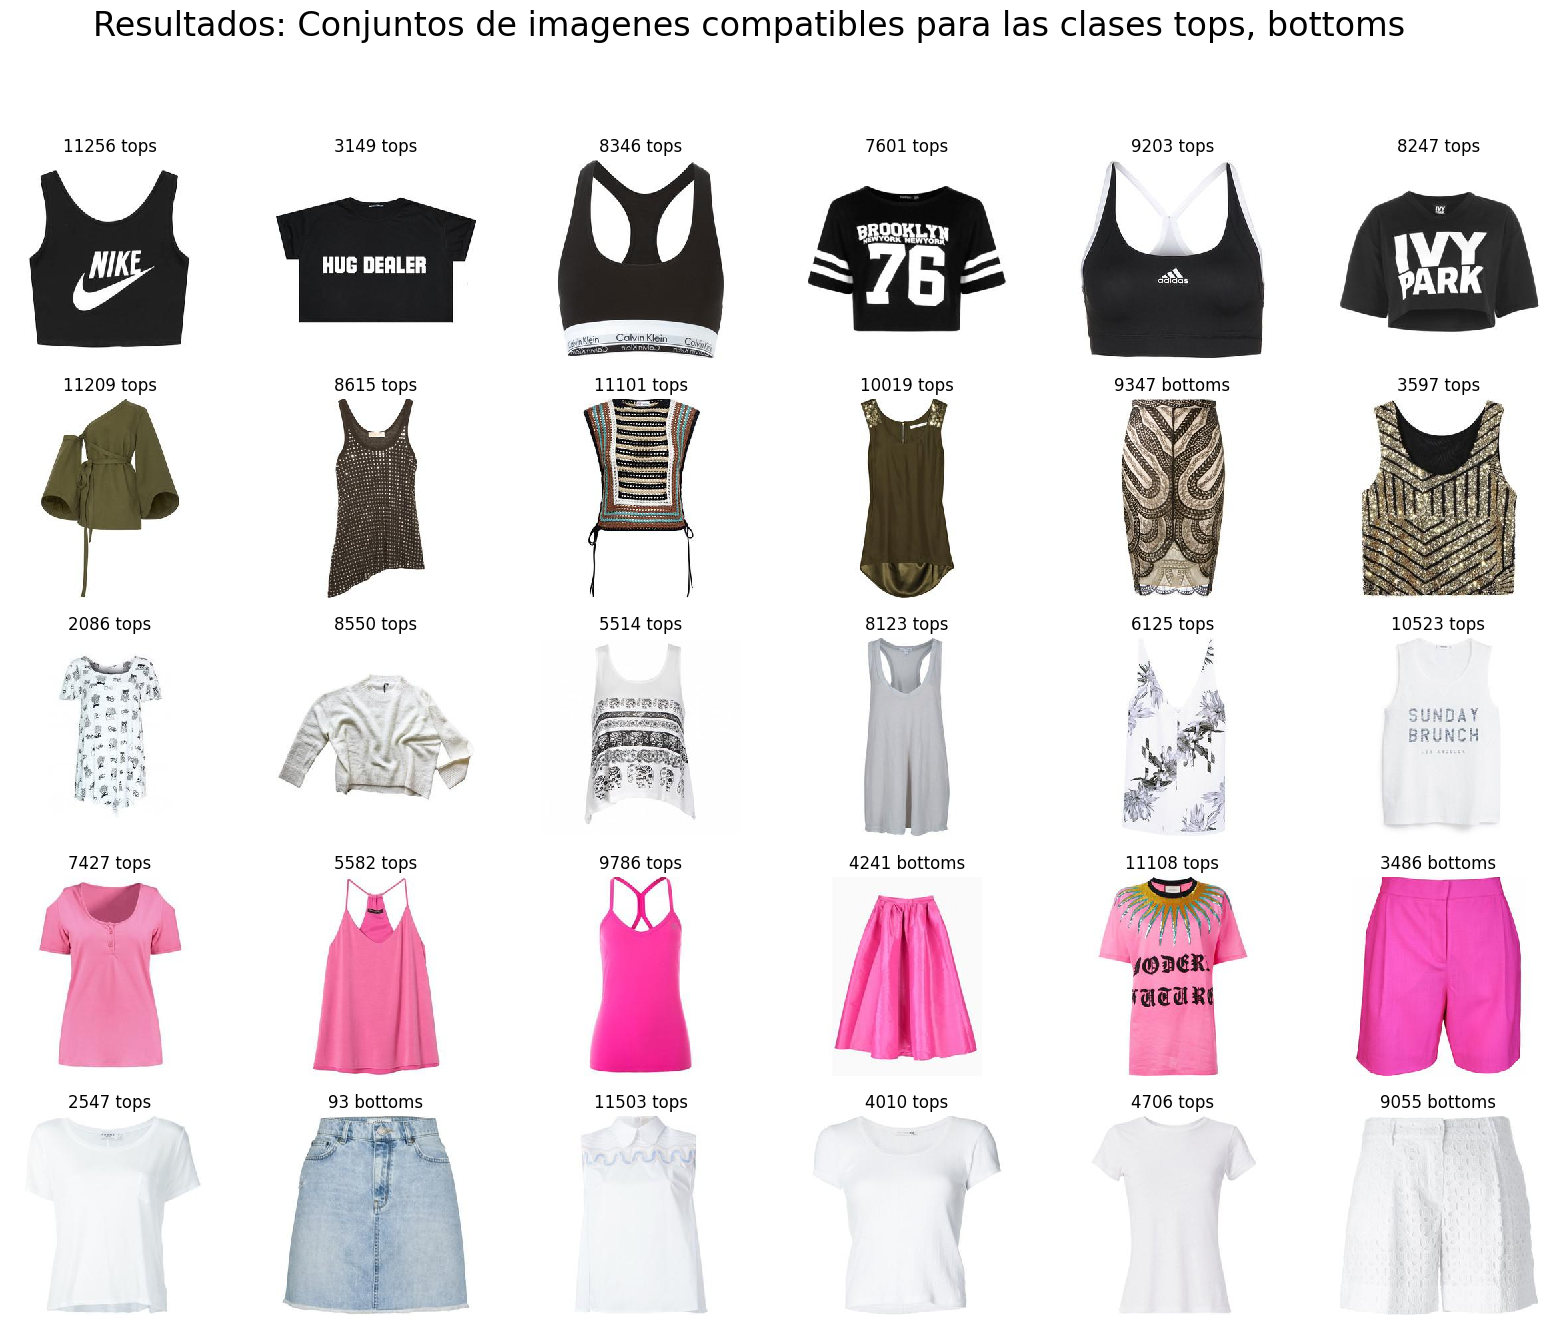

In [8]:
# si ocurre error DefaultCPUAllocator: can't allocate memory, reducir el num_workers y batch_size

from __future__ import print_function
import argparse
import os
import sys
import shutil
import json

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import Resnet_18
from polyvore_outfits import TripletImageLoader
from tripletnet_original import Tripletnet
from type_specific_network import TypeSpecificNet
import sys
import time
from PIL import Image
import itertools
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors



test_arg = False
use_fc_arg = True
learned_arg = True
prein_arg = True
epochs_args = 10
batch_size_args = 96
learning_rate_args = 5e-5
num_conditions = 5
learned_metric_arg = False


# names of model
name_arg = 'type_aware_%s_epochs_fc_%s_prein_%s' % (epochs_args, use_fc_arg, prein_arg)
resume_arg =  'runs/precise_models/%s/checkpoint.pth.tar' % (name_arg)
# Training settings
parser = argparse.ArgumentParser(description='Fashion Compatibility Example')
parser.add_argument('--batch-size', type=int, default=batch_size_args, metavar='N',
                    help='input batch size for training (default: 256)')
parser.add_argument('--epochs', type=int, default=epochs_args, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--start_epoch', type=int, default=1, metavar='N',
                    help='number of start epoch (default: 1)')
parser.add_argument('--lr', type=float, default=learning_rate_args, metavar='LR',
                    help='learning rate (default: 5e-5)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--resume', default=resume_arg, type=str,
                    help='path to latest checkpoint (default: none)')

parser.add_argument('--name', default=name_arg, type=str,
                    help='name of experiment')
parser.add_argument('--polyvore_split', default='nondisjoint', type=str,
                    help='specifies the split of the polyvore data (either disjoint or nondisjoint)')
parser.add_argument('--datadir', default='../../polyvore_type_aware_data', type=str,
                    help='directory of the polyvore outfits dataset (default: data)')
parser.add_argument('--test', dest='test', action='store_true', default=test_arg,
                    help='To only run inference on test set')
parser.add_argument('--dim_embed', type=int, default=64, metavar='N',
                    help='how many dimensions in embedding (default: 64)')
parser.add_argument('--use_fc', action='store_true', default=use_fc_arg,
                    help='Use a fully connected layer to learn type specific embeddings.')
parser.add_argument('--learned', dest='learned', action='store_true', default=learned_arg,
                    help='To learn masks from random initialization')
parser.add_argument('--prein', dest='prein', action='store_true', default=prein_arg,
                    help='To initialize masks to be disjoint')
parser.add_argument('--num_heads', dest='num_heads', action='store_true', default=4,
                    help='Amount of heads on')

parser.add_argument('--rand_typespaces', action='store_true', default=False,
                    help='randomly assigns comparisons to type-specific embeddings where #comparisons < #embeddings')
parser.add_argument('--num_rand_embed', type=int, default=4, metavar='N',
                    help='number of random embeddings when rand_typespaces=True')
parser.add_argument('--l2_embed', dest='l2_embed', action='store_true', default=True,
                    help='L2 normalize the output of the type specific embeddings')
parser.add_argument('--learned_metric', dest='learned_metric', action='store_true', default=False,
                    help='Learn a distance metric rather than euclidean distance')
parser.add_argument('--margin', type=float, default=0.3, metavar='M',
                    help='margin for triplet loss (default: 0.2)')
parser.add_argument('--embed_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for embedding norm')
parser.add_argument('--mask_loss', type=float, default=5e-4, metavar='M',
                    help='parameter for loss for mask norm')
parser.add_argument('--vse_loss', type=float, default=5e-3, metavar='M',
                    help='parameter for loss for the visual-semantic embedding')
parser.add_argument('--sim_t_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for text-text similarity')
parser.add_argument('--sim_i_loss', type=float, default=5e-5, metavar='M',
                    help='parameter for loss for image-image similarity')


os.environ["CUDA_VISIBLE_DEVICES"]="0"

def choose_random_elements(arr1, arr2, index, n):
    matching_indices = [i for i in range(len(arr2)) if arr2[i] == index]
    return random.sample(matching_indices, n)

def default_image_loader(path):
    return Image.open(path).convert('RGB')

def main(): 
    global args
    # torch.set_printoptions(threshold=10_000)
    torch.set_printoptions(profile="full")
    
    args = parser.parse_args()
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    fn = os.path.join(args.datadir, 'polyvore_outfits', 'polyvore_item_metadata.json')
    meta_data = json.load(open(fn, 'r'))
    text_feature_dim = 6000
    kwargs = {'num_workers': 8, 'pin_memory': True} if args.cuda else {}
    test_loader = torch.utils.data.DataLoader(
        TripletImageLoader(args, 'test', meta_data,
                           transform=transforms.Compose([
                               transforms.Resize(112),
                               transforms.CenterCrop(112),
                               transforms.ToTensor(),
                               normalize,
                           ]), return_image_path=True),
        batch_size=args.batch_size, shuffle=False, **kwargs)

    model = Resnet_18.resnet18(pretrained=True, embedding_size=args.dim_embed)
    csn_model = TypeSpecificNet(args, model, len(test_loader.dataset.typespaces))

    criterion = torch.nn.MarginRankingLoss(margin = args.margin)
    tnet = Tripletnet(args, csn_model, text_feature_dim, criterion)
    if args.cuda:
        tnet.cuda()
    
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume,encoding='latin1')
            args.start_epoch = checkpoint['epoch']
            best_acc = checkpoint['best_prec1']
            tnet.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(args.resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))
    
    
    # guardar la lista de embeddings de las imagenes, la lista de las categorias y la lista del path de las imagenes
    # para retirarlas
    embeddings_list, cat_list, images_list = [], [], []
    
    # for test/val data we get images only from the data loader
    for batch_idx, images_info in enumerate(test_loader):
        images, images_path, imgcat = images_info
    
        if args.cuda:
            images = images.cuda()
        images = Variable(images)
        
        # se guarda el embedding de la imagen, el path de la imagen y la categoria
        img_embedding = tnet.embeddingnet(images).data
        embeddings_list.append(img_embedding)
        images_list.append(images_path)
        cat_list.append(imgcat)
    
    # embeddings de las imagenes, path de las imagenes y categorias en formato de tensor de torch
    embeddings_list = torch.cat(embeddings_list)
    images_list = list(itertools.chain.from_iterable(images_list))
    cat_list = list(itertools.chain.from_iterable(cat_list))
    
    # se selecciona una condicion de typespaces de forma aleatoria
    typespaces = test_loader.dataset.typespaces
    example_cond = [9]
    # random.sample(range(0, 66), 1)
    
    # se obtienen las embeddings que solamente corresponden a la condicion establecida por example_cond
    # y se retiran las categorias asociadas a esa clase
    embeddings_list = embeddings_list[:, example_cond, :].squeeze().cpu()
    condition_value = {i for i in typespaces if typespaces[i]==example_cond[0]}
    class1, class2 = condition_value.pop()
    
    # leave only the vectors or images that correspond to class 1 or class 2
    embeddings_list2, cat_list2, images_list2 = [], [], []
    for i in range(len(embeddings_list)):
        if cat_list[i] == class1 or cat_list[i] == class2:
            img_embedding = torch.unsqueeze(embeddings_list[i,:].clone().detach(), 0)
            embeddings_list2.append(img_embedding)
            cat_list2.append(cat_list[i])
            images_list2.append(images_list[i])
    
    embeddings_list2 = torch.cat(embeddings_list2)
    
    # se eliguen n ejemplos que correspondan a la clase 1
    n_ejemplos = 5
    ejemplos = choose_random_elements(embeddings_list2, cat_list2, class1, n_ejemplos)

    # se define el modelo NearestNeighbors
    n_nbrs = 6
    nbrs = NearestNeighbors(n_neighbors=n_nbrs).fit(embeddings_list2)
    near_nei = nbrs.kneighbors(embeddings_list2[ejemplos, :], return_distance=False)
    
    # crear figura y subplots
    fig, ax = plt.subplots(n_ejemplos, n_nbrs, figsize=(20,15))
    for j in range(n_ejemplos):
        for i in range(n_nbrs):
            image_id = near_nei[j, i]
            example_img = default_image_loader(images_list2[image_id])
            ax[j,i].imshow(example_img, interpolation='nearest')
            titulo = str(image_id) + ' ' + cat_list2[image_id]
            
            ax[j, i].set_title(titulo)
            ax[j, i].axis('off')

    
    # titulo de la figura
    fig.suptitle('Resultados: Conjuntos de imagenes compatibles para las clases %s, %s' % (class1, class2), fontsize=24)
    
    # PLOT RESULTS AND SETS OF COMPATIBLE CLOTHES
    plot_results = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'plot_results')
    current_folder = 'image_sets'
    
    directory = os.path.join(plot_results, current_folder, args.name)
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    plot_name = os.path.join(directory, '{}.png'.format(int(time.time())))
    plt.savefig(plot_name)
    
if __name__ == '__main__':
    sys.argv = ['']
    main()
    
    
# torch.Size([256, 67, 64])

In [28]:
plot_results = os.path.join(os.path.dirname(os.getcwd()), 'plot_results')
print(plot_results)

/home/raraya/fashion_proj/fashion_models/plot_results


In [10]:
X = np.array([[28273, 20866, 29961],[12343, 45634, 29961], [0, 0, 0], [130, 1600, 781], [1500, 1700, 30]])
knn = NearestNeighbors(n_neighbors=4)
knn.fit(X)

knn.kneighbors(X[0].reshape(1,-1), return_distance=False)

NameError: name 'NearestNeighbors' is not defined

[[0 1]
 [1 0]
 [2 1]
 [3 4]
 [4 3]
 [5 4]]


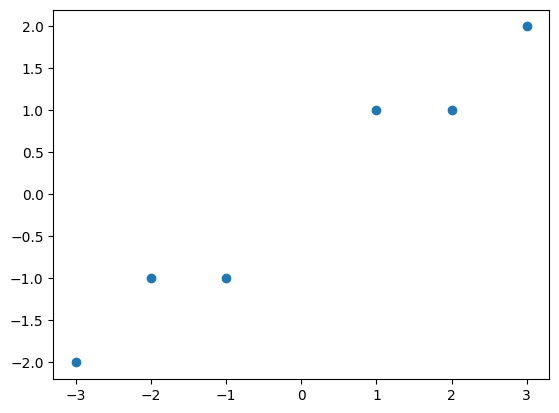

In [15]:
# mostrar los datos en X, Y
from sklearn.neighbors import NearestNeighbors
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
brs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

print(indices)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = X[:,0]
y = X[:,1]

ax.scatter(x, y)
plt.show()

## 4. Visualización de imágenes y *augmentaciones*

A continuación, como paso intermedio, se visualizan las imágenes y las augmentaciones para alimentar al modelo. Esto se importante puesto que la eficiencia depende del modelo depende directamente de las augmentaciones que se eligan.

In [ ]:
from __future__ import print_function
import argparse
import os
import sys
import shutil
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

# librerías importantes e importar BYOL
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
from polyvore_dataset_loader import DoubletImageLoader
from torch.nn import MSELoss

from bimodal_byol_shoes.data.custom_transforms import BatchTransform, ListToTensor, PadToSquare, SelectFromTuple, TensorToDevice
from bimodal_byol_shoes.models.BYOL2_model import BYOL2
from sklearn.neighbors import NearestNeighbors
import itertools
import random
import matplotlib.pyplot as plt
from PIL import Image
import time
    
def main():


     # path to important folders
    # path to important folders
    polyvore_dataset = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'polyvore_data')
    polyvore_images = os.path.join(polyvore_dataset, 'images')
    polyvore_info = os.path.join(polyvore_dataset, 'polyvore-info')
    category_info = os.path.join(polyvore_info, 'category_id.txt')
    
    d = {}
    with open(category_info) as f:
        for line in f:
            (key, val) = line.split(' ', 1)
            d[int(key)] = val
            
    category_data = open(category_info, 'r')
    
     # asegurarse que la carpeta exista
    models_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'fashion_proj', 'fashion_models', 'checkpoint_models')

    # revisa si hay gpu cuda sino ocupa cpu
    no_cuda = False # cambiar si se quiere ocupar  cuda
    cuda = not no_cuda and torch.cuda.is_available()   # CAMBIAR SI SE POSEEN RECURSOS COMO GPU
    device = torch.device("cuda" if cuda else "cpu")

    log_interval = 10
    text_feature_dim = 6000
    kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

    # pre-cargar modelos y evaluar en dataset de validacion o testeo
    val_arg = False
    test_arg = True
    resume = os.path.join(models_folder, 'model_best.pth.tar')

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

    transforms_1 = transforms.Compose([SelectFromTuple(0), TensorToDevice(device)])
    transforms_2 = transforms.Compose([SelectFromTuple(1), TensorToDevice(device)])

    # otros modelos importantes, codificador, se inicializa el modelo
    encoder = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    #encoder.load_state_dict(torch.load('../checkpoints/resnet50_byol_quickdraw_128_1000_v3.pt'))
    empty_transform = transforms.Compose([])
    epochs = 1
    epoch_size = 300
    byol_learner = BYOL2(
        encoder,
        image_size=224,
        hidden_layer='avgpool',
        augment_fn=empty_transform,
        cosine_ema_steps=epochs*epoch_size
    )



    byol_learner.augment1 = transforms_1
    byol_learner.augment2 = transforms_2

    # data parallel
    if cuda:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        byol_learner = nn.DistributedDataParallel(byol_learner)
    byol_learner.to(device)



    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)

            start_epoch = checkpoint['epoch']
            best_val_loss = checkpoint['best_prec1']
            byol_learner.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                    .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))


    # augmentación to apply
    augmentation = transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.RandomHorizontalFlip(),
                           normalize])



    # otros modelos importantes, codificador, se inicializa el modelo
    encoder = models.resnet50(weights='DEFAULT')

    # dataloader for the validation data
    val_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('test', polyvore_images, polyvore_info, transform=transforms.ToTensor()),
        batch_size=1, shuffle=True)
    
    
    ## COMENTAR DESPUES
    # dataloaders for training and validation da
    train_loader = torch.utils.data.DataLoader(
        DoubletImageLoader('train', polyvore_images, polyvore_info,
                           transform=transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               normalize,
                           ]), return_image_path=True),
        batch_size=1, shuffle=True, **kwargs)
    
    # get random image from the batch
    for batch_idx, image_info in enumerate(train_loader):
        img1, img1category, anchor_im, img2, img2category, pos_im, img3, img3category, neg_im = image_info
    ## HASTA ACA

    # get random image from the batch
    sample_tensor = None
    sample_category = None
    for batch_idx, image_info in enumerate(val_loader):
        sample_tensor, sample_category = image_info
        break

    # preprocess the tensor and augment it
    sample_tensor = sample_tensor.squeeze()
    augmentated_tensor = augmentation(sample_tensor)

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    sample_image = np.transpose(sample_tensor, (1, 2, 0))
    augmentated_image = np.transpose(augmentated_tensor, (1, 2, 0))
    
    image_cat = d[int(sample_category[0])]
    
    
    # crear figura y subplots
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(sample_image, interpolation='nearest')
    ax[0].set_title('Imagen original', fontweight ="bold")
    ax[0].axis('off')


    ax[1].imshow(augmentated_image, interpolation='nearest')
    ax[1].set_title('Imagen Augmentada', fontweight ="bold")
    ax[1].axis('off')

    # titulo de la figura
    fig.suptitle('Muestra de augmentación de imágen. Categoria {}'.format(image_cat), fontsize=16)


if __name__ == '__main__':
    main() 